# Load Libraries

In [26]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [58]:
library(DBI)
library(ggplot2)
library(tidyverse)
library(caret)
library(scales)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




# Connect to DB, load data, clean data

In [3]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [31]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_updates <- dbGetQuery(con, "
    SELECT *
    FROM analysis.what_did_updates_change
")

In [5]:
all_updates_sub <- all_updates[sample(nrow(all_updates), 100000),] 

In [32]:
all_updates <- all_updates %>% filter(ty != "zero_to_something")

In [33]:
all_updates$ty <- sapply(all_updates$ty, as.character)
all_updates$tyFact <- factor(all_updates$ty, levels=c("bug", "minor", "major"))

In [34]:
head(all_updates)

,from_id,to_id,package_id,ty,from_created,to_created,did_intro_vuln,did_patch_vuln,did_change_types,did_change_code,did_add_dep,did_remove_dep,did_modify_dep_constraint,did_change_json_scripts,tyFact
,<int64>,<int64>,<int64>,<chr>,<dttm>,<dttm>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>
1,45406,45407,44333,bug,2017-05-18 06:18:45,2017-05-18 06:27:38,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug
2,62778,62779,62967,bug,2017-07-26 00:40:30,2017-07-26 21:40:16,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug
3,62779,62780,62967,bug,2017-07-26 21:40:16,2017-07-26 21:52:26,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,bug
4,62781,62782,62968,minor,2017-07-24 11:54:37,2017-07-28 12:12:29,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,minor
5,62783,62784,62969,bug,2017-07-28 11:52:04,2017-07-28 12:01:41,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug
6,62785,62786,62972,bug,2017-07-26 22:16:20,2017-07-26 22:47:30,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug


In [35]:
all_updates <- all_updates %>% mutate(
    did_change_deps = did_add_dep | did_remove_dep | did_modify_dep_constraint,
    only_change_deps = (did_add_dep | did_remove_dep | did_modify_dep_constraint) & !(did_change_types | did_change_code | did_change_json_scripts),
    only_change_types = (did_add_dep | did_remove_dep | did_modify_dep_constraint) & !(did_change_types | did_change_code | did_change_json_scripts)
)

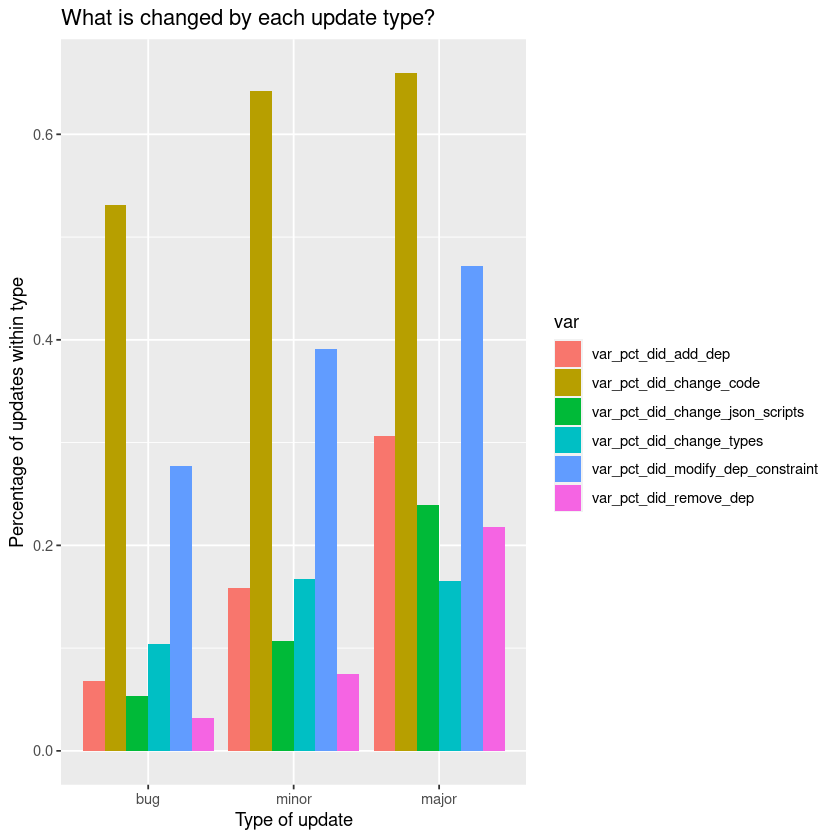

In [27]:
all_updates %>% group_by(tyFact) %>% summarise(
    n = n(), 
    # var_num_did_intro_vuln = sum(did_intro_vuln),
    # var_num_did_patch_vuln = sum(did_patch_vuln),
    var_num_did_change_types = sum(did_change_types),
    var_num_did_change_code = sum(did_change_code),
    var_num_did_add_dep = sum(did_add_dep),
    var_num_did_remove_dep = sum(did_remove_dep),
    var_num_did_modify_dep_constraint = sum(did_modify_dep_constraint),
    var_num_did_change_json_scripts = sum(did_change_json_scripts)
) %>%
mutate(
    # var_pct_did_intro_vuln = var_num_did_intro_vuln / n,
    # var_pct_did_patch_vuln = var_num_did_patch_vuln / n,
    var_pct_did_change_types = var_num_did_change_types / n,
    var_pct_did_change_code = var_num_did_change_code / n,
    var_pct_did_add_dep = var_num_did_add_dep / n,
    var_pct_did_remove_dep = var_num_did_remove_dep / n,
    var_pct_did_modify_dep_constraint = var_num_did_modify_dep_constraint / n,
    var_pct_did_change_json_scripts = var_num_did_change_json_scripts / n
) %>% pivot_longer(
    cols = starts_with("var_pct_"),
    names_to = "var",
    values_to = "val"
) %>% ggplot(aes(x = tyFact, y = val, fill = var)) +
    geom_col(position="dodge") +
    # facet_wrap(~var, scales = "free_y") +
    # theme_minimal() +
    # theme(legend.position = "none") +
    labs(x = "Type of update", y = "Percentage of updates within type", title = "What is changed by each update type?")

#  %>% ggplot(aes(x = tyFact, y = pct, fill = tyFact)) + 
#     geom_bar(stat = "identity") + 
#     facet_wrap(~var, scales = "free_y") + 
#     theme_minimal() + 
#     theme(legend.position = "none") + 
#     labs(x = "Type of update", y = "Proportion of updates", title = "What proportion of updates change each type of thing?")


In [50]:
all_updates %>% summarize(total_did_change_deps=sum(did_change_deps))

total_did_change_deps
<int>
5479605


In [55]:
as.data.frame(confusionMatrix(factor(all_updates$did_change_deps), factor(all_updates$did_change_code))$table)

Prediction,Reference,Freq
<fct>,<fct>,<int>
FALSE,FALSE,3680405
TRUE,FALSE,2985068
FALSE,TRUE,5743011
TRUE,TRUE,2494537


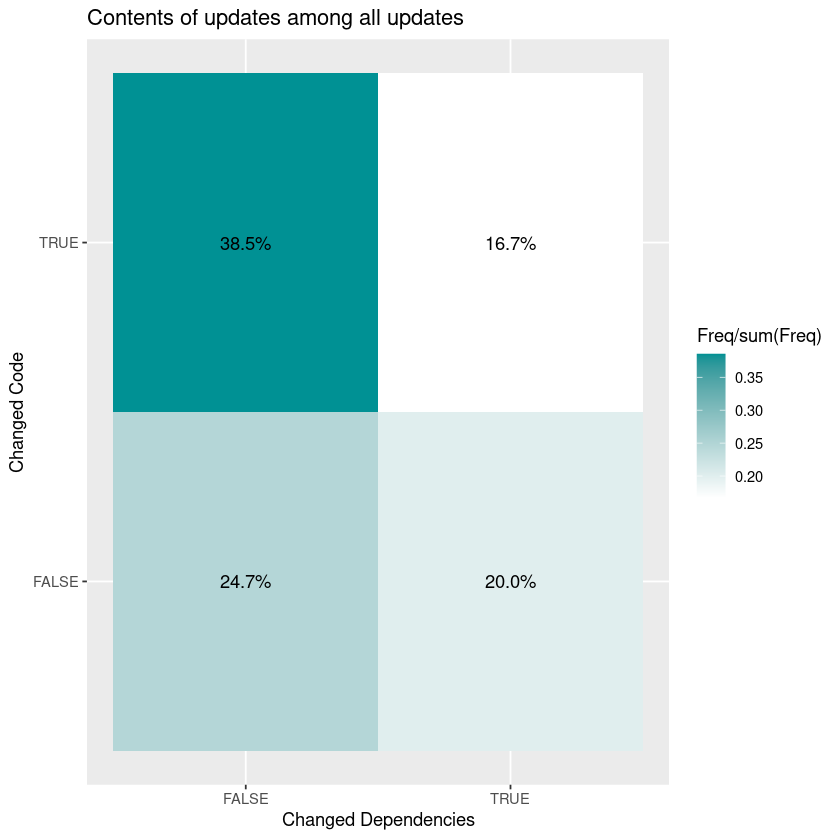

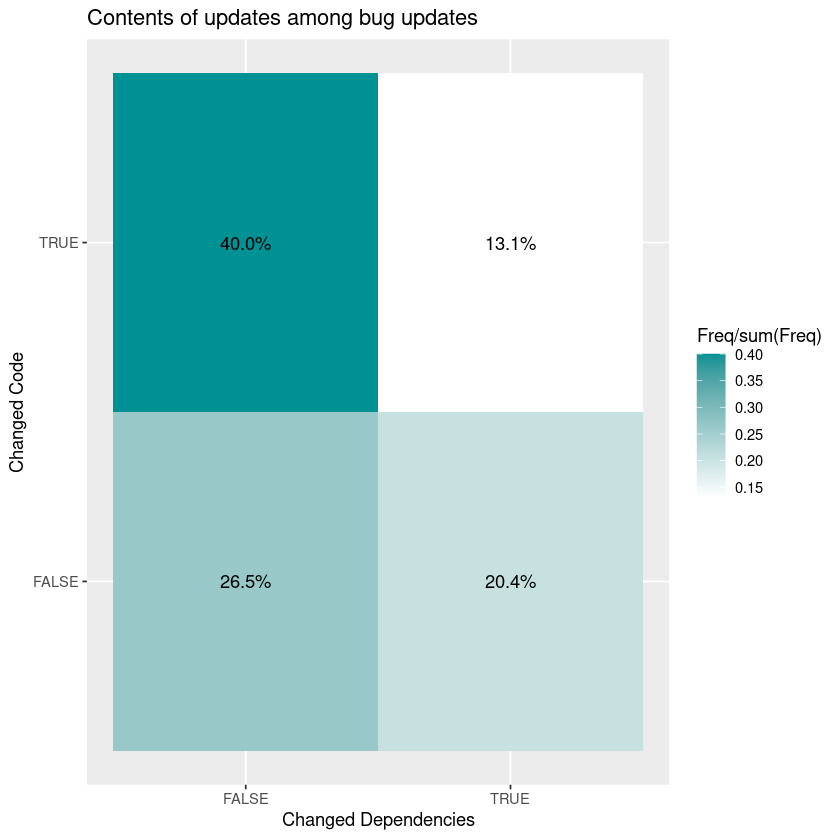

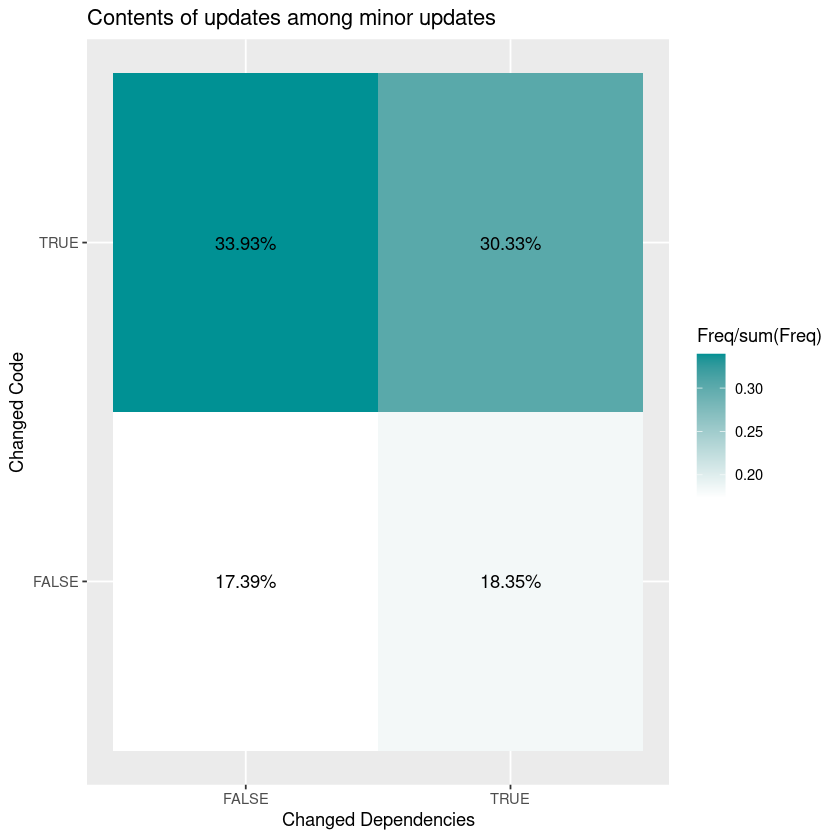

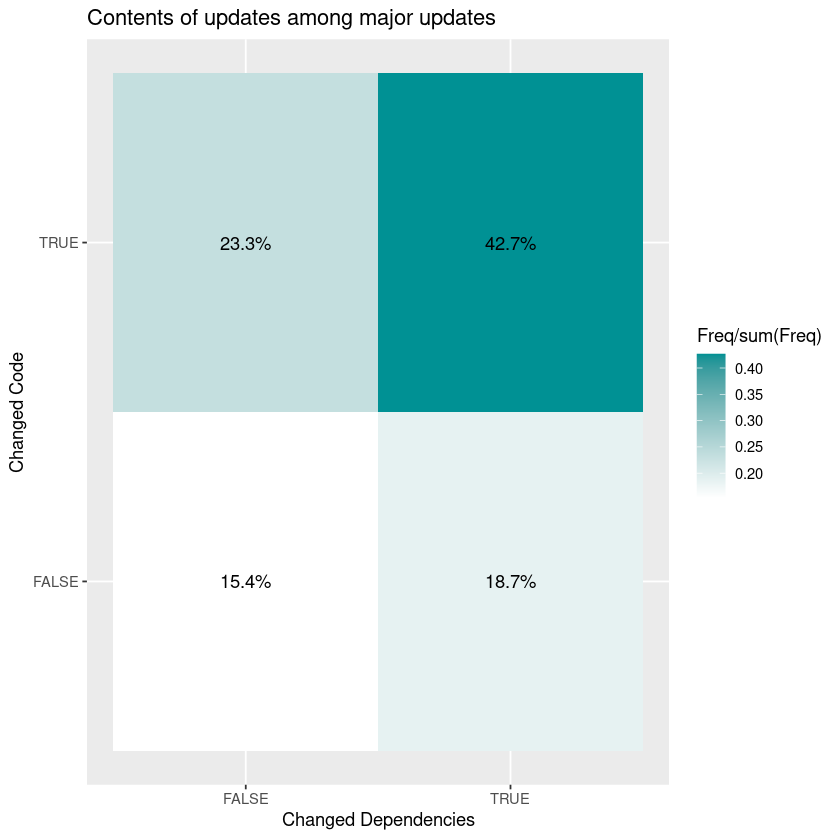

In [69]:
plot_change_deps_vs_code <- function(df, update_type) {
        cm <- confusionMatrix(factor(df$did_change_deps), factor(df$did_change_code)) # preds, refs
        cm <- as.data.frame(cm$table)
        # cm$Prediction <- factor(cm$Prediction, levels=rev(levels(cm$Prediction)))
        # cm <- cm %>% mutate(Freq = Freq / sum(Freq))

        ggplot(cm, aes(Prediction,Reference, fill=Freq / sum(Freq))) +
                geom_tile() + geom_text(aes(label=scales::percent(Freq / sum(Freq)))) +
                scale_fill_gradient(low="white", high="#009194") +
                labs(x = "Changed Dependencies", y = "Changed Code") +
                ggtitle(paste("Contents of updates among", update_type, "updates"))
                # scale_x_discrete(labels=c("Class_1","Class_2")) +
                # scale_y_discrete(labels=c("Class_4","Class_3"))
}

plot_change_deps_vs_code(all_updates, "all")
plot_change_deps_vs_code(all_updates %>% filter(ty == "bug"), "bug")
plot_change_deps_vs_code(all_updates %>% filter(ty == "minor"), "minor")
plot_change_deps_vs_code(all_updates %>% filter(ty == "major"), "major")

# Make plots!

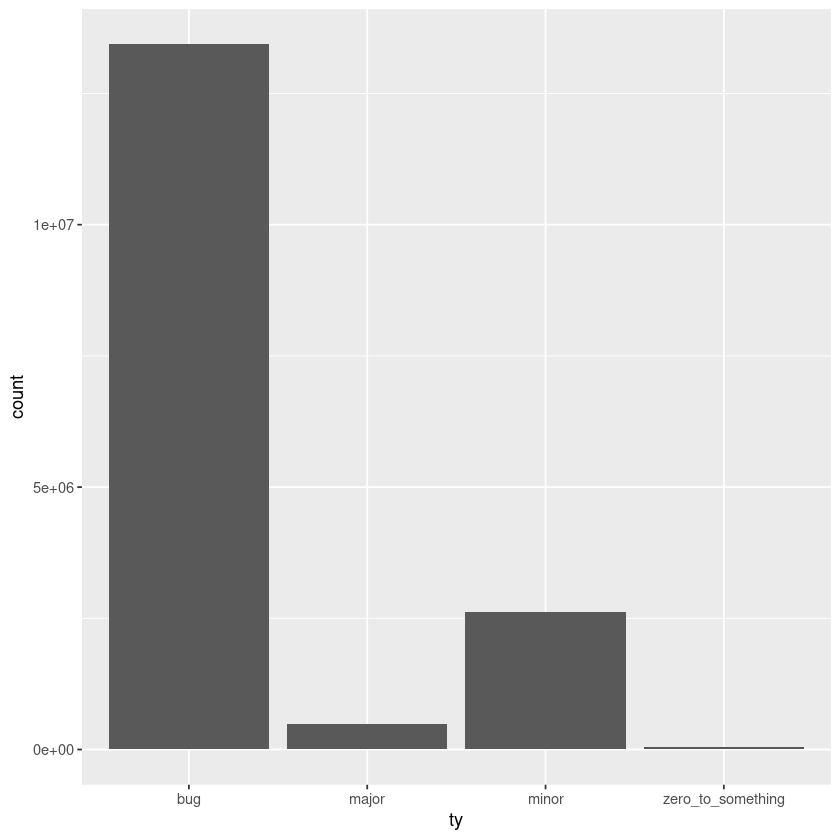

In [32]:
# Takes about 20 seconds
ggplot(data = all_updates, aes(x = ty)) +
    geom_bar()

### What proportion of each package's update are each type?

In [97]:
# creates a data frame with one row per package, and columns for count of each update type
update_changes_by_pkg <- all_updates %>%
    group_by(package_id,tyFact,did_change_deps,did_change_code) %>%
    summarise(
        count = n()
    ) %>% mutate(
        change=ifelse(did_change_deps & did_change_code, "both", ifelse(did_change_deps, "deps", ifelse(did_change_code, "code", "none"))),
    ) %>% pivot_wider(names_from = change, values_from = count, values_fill=0) %>%
    group_by(package_id,tyFact) %>% summarise(
        # total = sum(both, deps, code, none),
        # bothPct = both / total,
        # depsPct = deps / total,
        # codePct = code / total,
        # nonePct = none / total
        total_deps = sum(deps),
        total_code = sum(code),
        total_both = sum(both),
        total_none = sum(none),
    ) %>% mutate(
        total = total_deps + total_code + total_both + total_none,
        bothPct = total_both / total,
        depsPct = total_deps / total,
        codePct = total_code / total,
        nonePct = total_none / total
    ) %>% pivot_longer(
        cols = ends_with("Pct"),
        names_to = "change",
        values_to = "pct"
    ) 
    
    # %>% ggplot(aes(x = tyFact, y = pct, fill = change)) +
    
    # %>% pivot_longer(
    #     cols = starts_with("none"),
    #     names_to = "change",
    #     values_to = "pct"
    # ) %>% ggplot(aes(x = tyFact, y = pct, fill = change)) +
    # mutate(total = bug + minor + major,
    #        bugPct = bug / total,
    #        majorPct = major / total,
    #        minorPct = minor / total,
    # ) %>%
    # mutate(update_action = ifelse(did_intro_vuln, 'Intro vuln', ifelse(did_patch_vuln, 'Patch vuln', 'No security effect')))

`summarise()` has grouped output by 'package_id', 'tyFact', 'did_change_deps'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'package_id'. You can override using the
`.groups` argument.


In [98]:
update_changes_by_pkg

package_id,tyFact,total_deps,total_code,total_both,total_none,total,change,pct
<int64>,<fct>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>
335,bug,2,73,1,74,150,bothPct,0.006666667
335,bug,2,73,1,74,150,depsPct,0.013333333
335,bug,2,73,1,74,150,codePct,0.486666667
335,bug,2,73,1,74,150,nonePct,0.493333333
335,minor,2,139,22,19,182,bothPct,0.120879121
335,minor,2,139,22,19,182,depsPct,0.010989011
335,minor,2,139,22,19,182,codePct,0.763736264
335,minor,2,139,22,19,182,nonePct,0.104395604
335,major,1,6,4,1,12,bothPct,0.333333333


In [101]:
update_changes_by_pkg$tyFact <- recode(update_changes_by_pkg$tyFact, bug='Bug', minor='Minor', major='Major')


In [103]:
update_changes_by_pkg$change <- recode(update_changes_by_pkg$change, nonePct='Neither', bothPct='Both', depsPct='Dependencies', codePct='Code')
update_changes_by_pkg$change <- factor(update_changes_by_pkg$change, levels=c('Neither', 'Dependencies', 'Code', 'Both'))

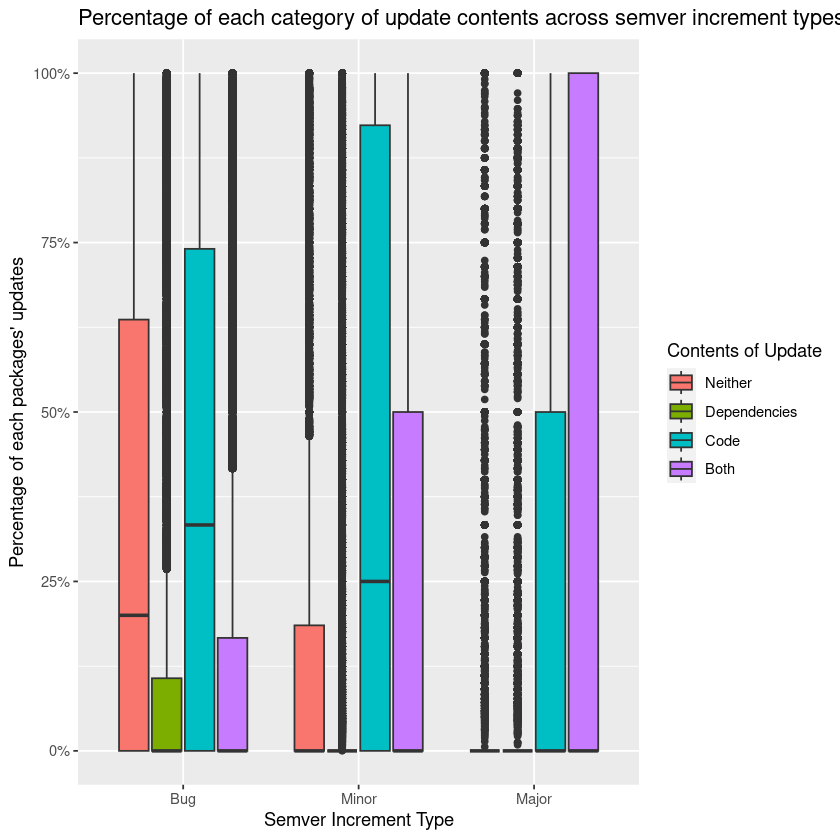

In [104]:
# box plots of the percentage of updates that are each type
ggplot(data = update_changes_by_pkg, aes(x = tyFact, y = pct, fill=change)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(title = "Percentage of each category of update contents across semver increment types", fill='Contents of Update', x='Semver Increment Type', y = 'Percentage of each packages\' updates')

In [91]:
head(updateCountsByPackage)

package_id,did_intro_vuln,did_patch_vuln,bug,major,minor,zero_to_something,total,bugPct,majorPct,minorPct,update_action
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
335,FALSE,FALSE,150,12,182,0,344,0.4360465,0.03488372,0.5290698,No security effect
336,FALSE,FALSE,2,0,0,1,2,1.0000000,0.00000000,0.0000000,No security effect
337,FALSE,FALSE,1,0,0,0,1,1.0000000,0.00000000,0.0000000,No security effect
341,FALSE,FALSE,384,18,233,0,635,0.6047244,0.02834646,0.3669291,No security effect
488,FALSE,FALSE,1,1,0,0,2,0.5000000,0.50000000,0.0000000,No security effect
2580,FALSE,FALSE,2,0,1,0,3,0.6666667,0.00000000,0.3333333,No security effect


In [92]:
# make a long version of it for ggplot
updateCountsByPackageLong <- updateCountsByPackage %>%
    pivot_longer(cols=ends_with("Pct"), names_to="ty", values_to="pct")

In [93]:
updateCountsByPackageLong$update_action <- factor(updateCountsByPackageLong$update_action, levels=c('No security effect', 'Intro vuln', 'Patch vuln'))
updateCountsByPackageLong$ty <- recode(updateCountsByPackageLong$ty, bugPct='Bug', minorPct='Minor', majorPct='Major')
updateCountsByPackageLong$ty <- factor(updateCountsByPackageLong$ty, levels=c('Bug', 'Minor', 'Major'))

In [94]:
head(updateCountsByPackageLong)

package_id,did_intro_vuln,did_patch_vuln,bug,major,minor,zero_to_something,total,update_action,ty,pct
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
335,FALSE,FALSE,150,12,182,0,344,No security effect,Bug,0.43604651
335,FALSE,FALSE,150,12,182,0,344,No security effect,Major,0.03488372
335,FALSE,FALSE,150,12,182,0,344,No security effect,Minor,0.52906977
336,FALSE,FALSE,2,0,0,1,2,No security effect,Bug,1.00000000
336,FALSE,FALSE,2,0,0,1,2,No security effect,Major,0.00000000
336,FALSE,FALSE,2,0,0,1,2,No security effect,Minor,0.00000000


Warning message:
“Removed 28797 rows containing non-finite values (`stat_boxplot()`).”


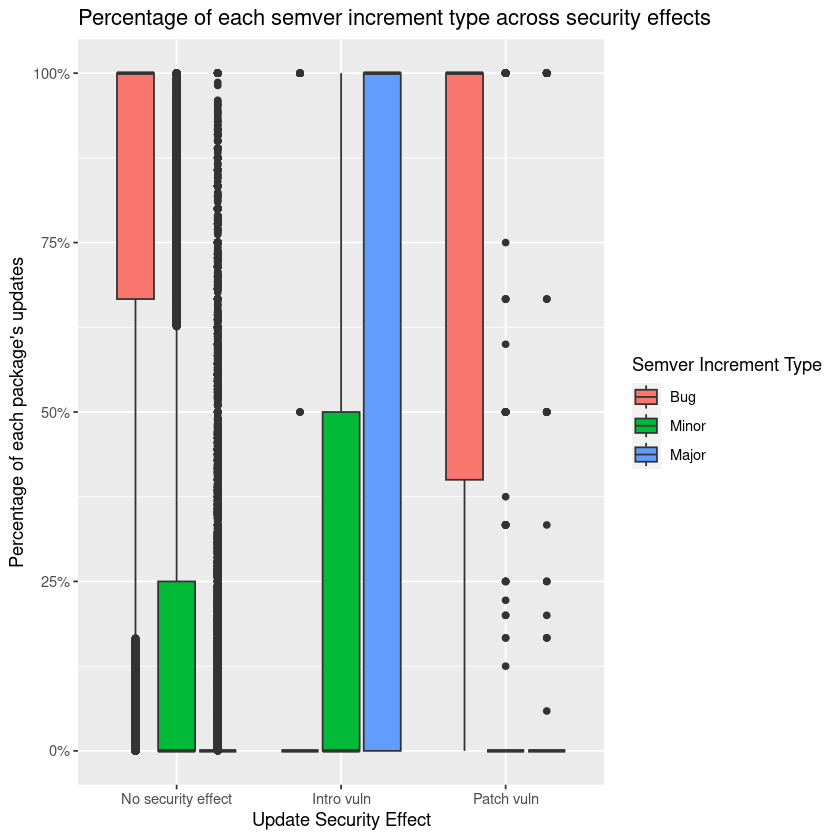

In [95]:
# box plots of the percentage of updates that are each type
ggplot(data = updateCountsByPackageLong, aes(x = update_action, y = pct, fill=ty)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(title = "Percentage of each semver increment type across security effects", fill='Semver Increment Type', x='Update Security Effect', y = 'Percentage of each package\'s updates')

package_id,major,minor,bug,none,total,majorPct,minorPct,bugPct,nonePct
<int64>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
335,12,182,150,0,344,0.03488372,0.5290698,0.4360465,0
336,0,0,2,0,3,0.00000000,0.0000000,0.6666667,0
337,0,0,1,0,1,0.00000000,0.0000000,1.0000000,0
341,18,233,384,0,635,0.02834646,0.3669291,0.6047244,0
488,1,0,1,0,2,0.50000000,0.0000000,0.5000000,0
2580,0,1,2,0,3,0.00000000,0.3333333,0.6666667,0
